In [110]:
import pystan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.stats as stats
from multiprocessing import Pool
import sys
import pickle

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

In [155]:
from IPython.display import HTML
HTML('''<script>$("div.output_stderr").hide();</script>''')

# Define some functions to implement the algorithm

In [275]:
# some constants that we use throughout.
Lprime, warmup, L, N = 250, 250, 2**7-1, 10000

def get_n_eff(fit, variables):
    '''
    annoying helper to find the n-eff from the stan summary
    '''
    summary_ = fit.summary()
    variables_updated = variables + [v+'[0]' for v in variables]
    neff = dict([(name, summary[-2]) for (name, summary) in zip(summary_['summary_rownames'], summary_['summary']) if name in variables_updated])
    for k,v in neff.items():
        if '[0]' in k:
            neff[k[:k.index('[0]')]] = neff.pop(k)
    return neff

def get_last_sample(la):
    '''
    another annoying helper to find the last sample from the stan fit so that we can 
    initialize a new chain with this sample (for continued sampling) thus avoiding the need
    to burn-in again.
    '''
    last_samp = {}
    for k, val in la.items():
        if k != 'lp__':
             last_samp[k] = val[-1]
    return last_samp

def run_experiment_alg1(data_gen, model, variables):
    '''
    Algorithm 1 from the paper
    '''
    result = {}
    
    # draw a prior sample and simulated dataset
    exp_data = data_gen()
    
    # draw L posterior samples
    fit = model.sampling(data=exp_data, iter=warmup+L, warmup=warmup, chains=1)
    la = fit.extract(permuted=True)
    
    # for each variable follow Alg
    for k in variables:
        samples = la.get(k)
        if len(samples.shape) == 1:
            theta_l = samples[:]
            rankf = np.sum(theta_l < exp_data[k])
        else:
            theta_l = samples[:,0]
            rankf = np.sum(theta_l < exp_data[k][0])
        result[k] = rankf
    return result

def run_experiment_alg2(data_gen, model, variables):
    '''
    Algorithm 2 from the paper
    '''
    result = {}
    
    # draw a prior sample and simulated dataset
    exp_data = data_gen()
    
    # draw L posterior samples
    fit = model.sampling(data=exp_data, iter=warmup+Lprime, warmup=warmup, chains=1)
    la = fit.extract(permuted=True)
    init = [get_last_sample(la)]
    
    # get the effective sample sizes (comment this out if you want to run Alg1)
    neff = get_n_eff(fit, variables)
    for var in variables:
        if neff[var] < L:
            # carry on sampling by L' L/Neff samples
            new_num_samples = int(Lprime * L/neff[var])
            fit2 = model.sampling(data=exp_data, iter=new_num_samples+100, warmup=100, chains=1, init=init)
            la2 = fit2.extract(permuted=True)
            neff2 = get_n_eff(fit2, variables)
            # add the new samples to the stored data
            for k,v in la.items():
                la[k] = np.concatenate([v,la2[k]])
                if k in variables:
                    neff[k] += neff2[k]
                
    # for each variable follow Alg
    for k in variables:
        # uniformly thin the resulting states
        samples = la[k]
        length = np.max(samples.shape)
        indexes = list(range(0,length,length//L))[:L]
        if len(samples.shape) == 1:
            theta_l = samples[indexes]
            rankf = np.sum(theta_l < exp_data[k])
        else:
            theta_l = samples[indexes,0]
            rankf = np.sum(theta_l < exp_data[k][0])
        result[k] = rankf
    return result

def algorithm(data_gen, experiment, variables, alg=1):
    '''
    These algorithms take some time so let us run this in parallel as much as 
    possible
    '''
    results_var = dict([(v, np.zeros(N, dtype=np.int16)) for v in variables])
    
    # using 6 processes
    pool = Pool(6)

    results = []
    for n in range(0,N):
        # choose which algorithm 
        if alg == 1:
            results.append(pool.apply_async(run_experiment_alg1, args=(data_gen, experiment, variables, )))
        else:
            results.append(pool.apply_async(run_experiment_alg2, args=(data_gen, experiment, variables, )))

    for i,result in enumerate(results):
        res = result.get()
        for var in variables:
            results_var[var][i] = res[var]
    return results_var

# Linear Regression

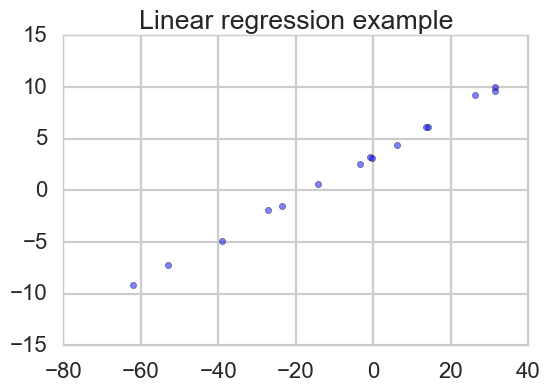

In [395]:
def generate_data1(prior_sd=10):
    '''
    Generate data from the linear regression problem
    '''
    N = 15
    X = np.array(np.random.uniform(-10,10, size=N))
    
    alpha = np.random.normal(0, prior_sd)
    beta = np.random.normal(0, prior_sd)
    
    Y = np.zeros(N)
    for i in range(N):
        Y[i] = np.random.normal(alpha + X[i]*beta, 1.2)
    return {'alpha': alpha, 'beta': beta, 'X': X, 'y': Y, 'N': N}

exp1_data = generate_data1()

plt.scatter(exp1_data['y'],exp1_data['X'], alpha=0.5)
plt.title('Linear regression example')
plt.show()

### Stan Model:

In [396]:
exp1_code = '''
data {
    int<lower=1> N;
    vector[N] X;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
}

model {
    alpha ~ normal(0,10); // change SD to 1 for the tight prior
    beta ~ normal(0,10);  // change SD to 1 for the tight prior
    y ~ normal(alpha + X*beta, 1.2);
}
'''
# Run only to compile:
# exp1 = pystan.StanModel(model_code=exp1_code)
# exp_tight_prior = pystan.StanModel(model_code=exp1_code)

In [465]:
exp1_data['alpha'], exp1_data['beta']

(-16.816098075047613, 4.8768564900465385)

In [403]:
fit = exp1.sampling(data=exp1_data)
fit

Inference for Stan model: anon_model_e5a47ffc0d087f8e716182d3ba1541e2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha -16.65  6.4e-3   0.32 -17.28 -16.87 -16.65 -16.43 -16.02   2507    1.0
beta    4.91  1.0e-3   0.05   4.81   4.87   4.91   4.95   5.01   2698    1.0
lp__   -7.81    0.02   0.95 -10.45  -8.17  -7.52  -7.14  -6.88   1759    1.0

Samples were drawn using NUTS at Tue May  8 09:26:59 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

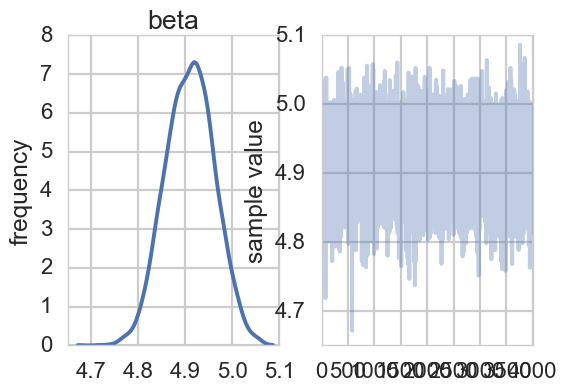

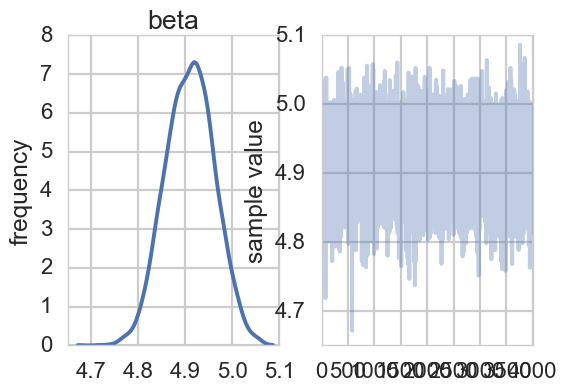

In [404]:
fit.traceplot('beta')

# Linear Regression - Calibration Check

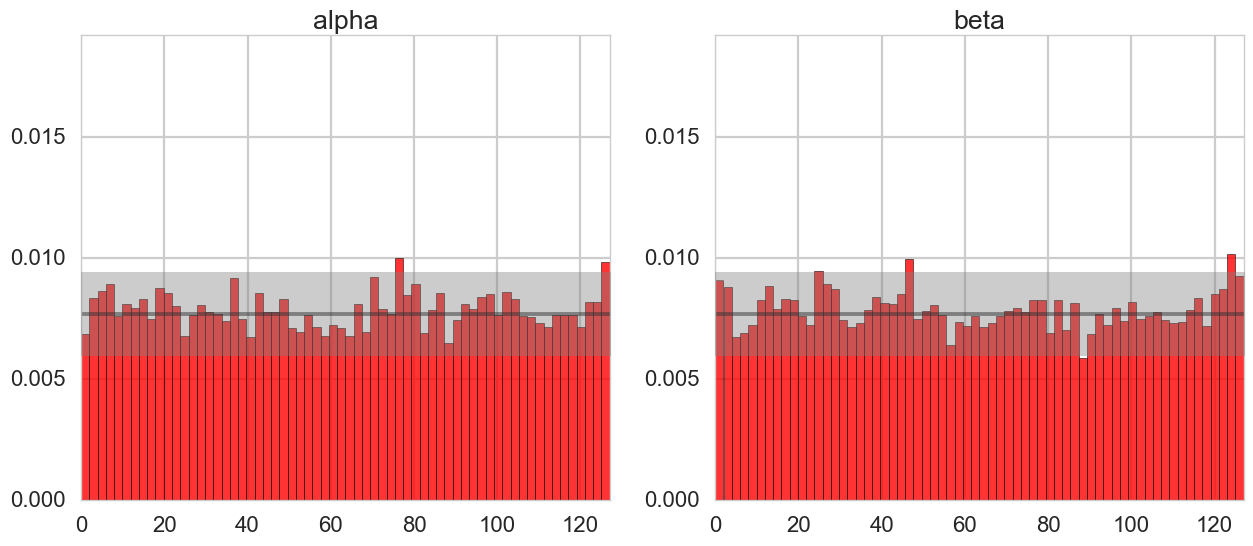

In [477]:
# results_alpha, results_beta = algorithm(generate_data1, exp1, ['alpha', 'beta'], alg=1).values()

fig, axes = plt.subplots(1,2,figsize=(15,6))
bins = (L+1)//2

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(results_alpha, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[1].hist(results_beta, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
axes[1].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)

axes[0].set_xlim([0,L])
axes[1].set_xlim([0,L])
axes[0].set_ylim([0,3*bins/N])
axes[1].set_ylim([0,3*bins/N])

plt.show()

# Linear Regression (ctd)
Now we run the same model but where we have mis-specified the prior. We are expecting to see evidence of an underdispersed data-averaged posterior.

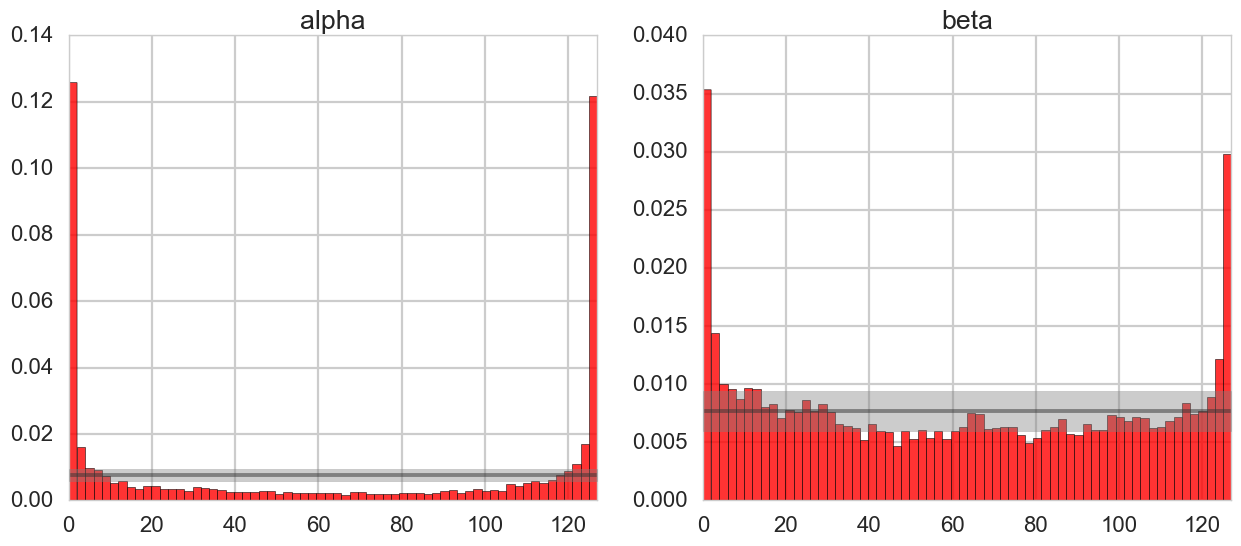

In [478]:
# results_alphat, results_betat = algorithm(generate_data1, exp_tight_prior, ['alpha', 'beta'], alg=1).values()

fig, axes = plt.subplots(1,2,figsize=(15,6))
bins = (L+1)//2

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(results_alphat, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[1].hist(results_betat, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
axes[1].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)

axes[0].set_xlim([0,L])
axes[1].set_xlim([0,L])

plt.show()

# Linear Regression - test against Cook, Gelman, Rubin calibration: 

In [72]:
N = 10000
quantiles = {'alpha': np.zeros(N, dtype=np.float16), 'beta': np.zeros(N, dtype=np.float16)}

for i in range(N):
    theta_sample = generate_data1()
    fit = exp1.sampling(data=theta_sample, iter=1000, warmup=750, chains=1)
    la = fit.extract(permuted=True)
    
    for theta in ['alpha', 'beta']:
        samp_theta = la.get(theta)
        abs_theta = np.abs(la.get(theta))
        quantile = np.sum(abs_theta*(samp_theta < theta_sample[theta])/np.sum(abs_theta))
        quantiles[theta][i] = quantile

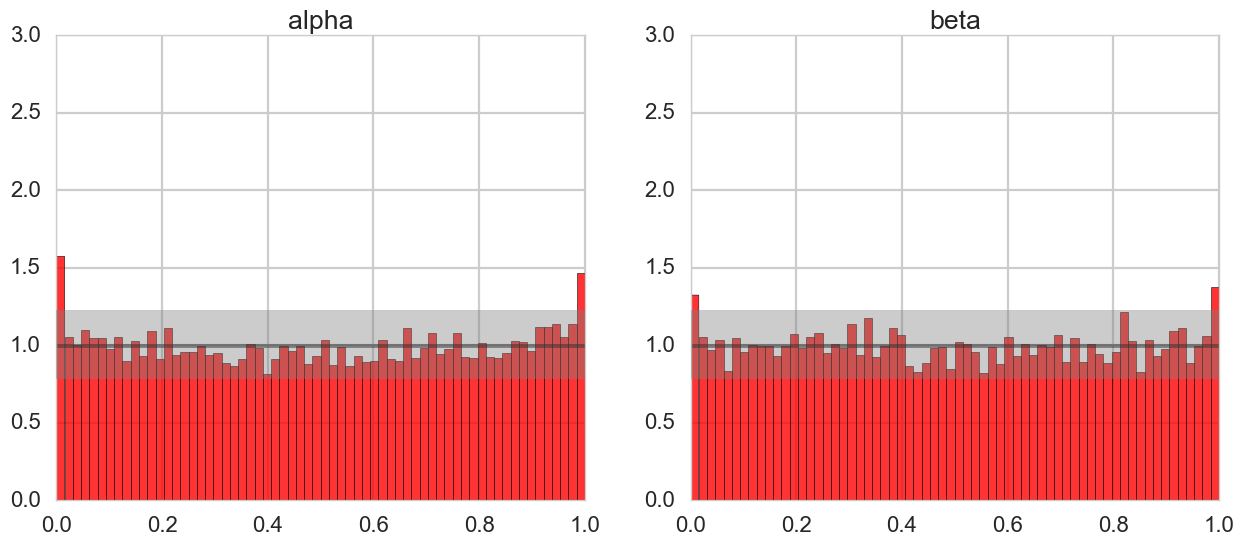

In [175]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
# bins = (1+1)//2

end_points = stats.binom(n=N, p=1/(bins)).interval(0.995)
median = stats.binom(n=N, p=1/(bins), loc=0).median()

axes[0].hist(quantiles['alpha'], alpha=0.8, normed=True, color='r', bins=bins, range=[0,1])
axes[1].hist(quantiles['beta'], alpha=0.8, normed=True, color='r', bins=bins, range=[0,1])
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/(N/bins), alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N/bins), y2=end_points[1]/(N/bins), color='gray', alpha=0.4, zorder=100)
axes[1].axhline(y=median/(N/bins), alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N/bins), y2=end_points[1]/(N/bins), color='gray', alpha=0.4, zorder=100)

axes[0].set_xlim([0,1])
axes[1].set_xlim([0,1])

axes[0].set_ylim([0,3])
axes[1].set_ylim([0,3])

plt.show()

# Linear Regression - Test ADVI for this task

In [434]:
# adjust alg1 to allow for the ADVI code

def get_advi_param(fit, var):
    return np.array([param for param, name in zip(fit.get('sampler_params'),fit.get('sampler_param_names')) if name == var][0])

def run_experiment_alg1_advi(data_gen, model, variables):
    '''
    Algorithm 1 from the paper
    '''
    result = {}
    
    # draw a prior sample and simulated dataset
    exp_data = data_gen()
    
    # draw L posterior samples
    fit = model.vb(data=exp_data, output_samples=L, algorithm='meanfield')
    
    # for each variable follow Alg
    for k in variables:
        samples = get_advi_param(fit, k)
        theta_l = samples
        rankf = np.sum(theta_l < exp_data[k])
        result[k] = rankf
    return result

In [435]:
# don't run this unless you absolutely have to. ADVI has an annoying print statement. Rather run separate 
# script in ./run_advi_experiment.py

# N_ = 500

# rank_alpha = []
# rank_beta = []
    
# for i in range(N_):
#     res = run_experiment_alg1_advi(generate_data1, exp1, ['alpha', 'beta'])
#     rank_alpha.append(res['alpha'])
#     rank_beta.append(res['beta'])
#     warnings.simplefilter('ignore')

In [436]:
# stupid WARNINGS
# HTML('''<script>$("div.output_stderr").hide();</script>''')

In [479]:
advi_ranks = pickle.load(open('./advi_results.pkl', 'rb'))
alpha_mf, beta_mf, alpha_fr, beta_fr = advi_ranks['alpha_mf'],advi_ranks['beta_mf'],advi_ranks['alpha_fr'],advi_ranks['beta_fr']

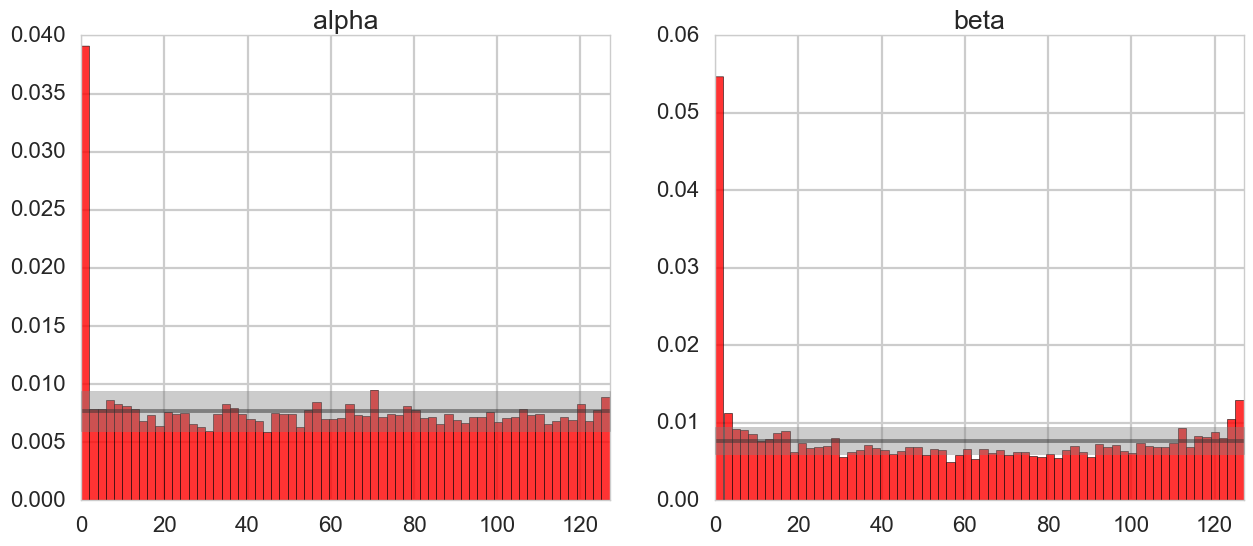

In [481]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
# bins = (1+1)//2

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(alpha_mf, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[1].hist(beta_mf, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
axes[1].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)

axes[0].set_xlim([0,L])
axes[1].set_xlim([0,L])

plt.show()

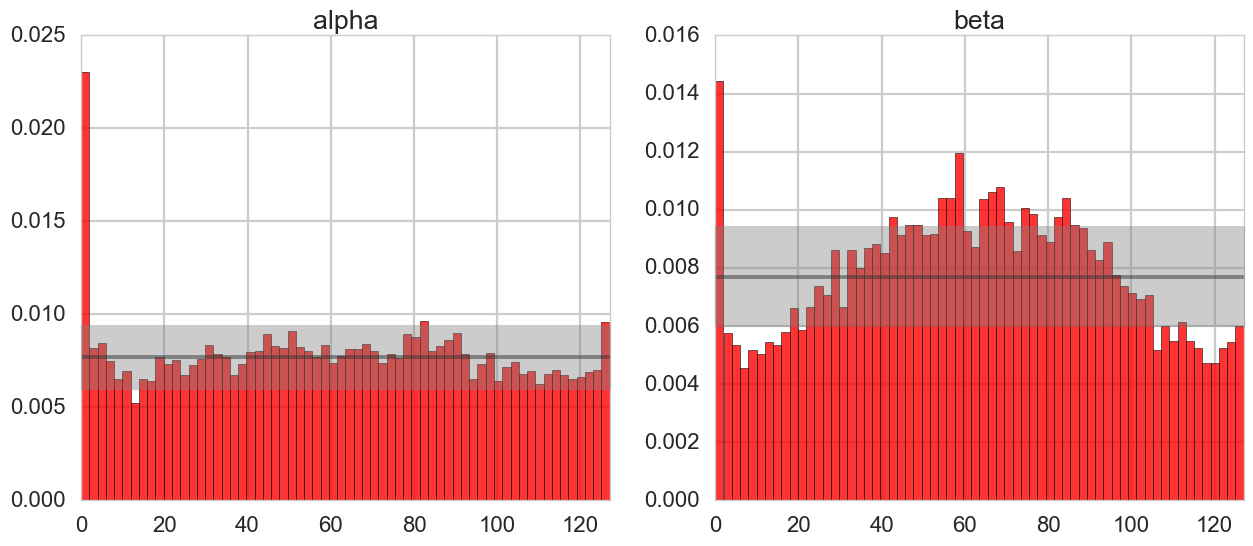

In [482]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
# bins = (1+1)//2

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(np.array(alpha_fr), alpha=0.8, normed=True, color='r', bins=bins, range=(0,L))
axes[1].hist(np.array(beta_fr), alpha=0.8, normed=True, color='r', bins=bins, range=(0,L))
axes[0].set_title('alpha')
axes[1].set_title('beta')

axes[0].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[0].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
axes[1].axhline(y=median/(N*2), alpha=0.5, color='black')
axes[1].fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)

axes[0].set_xlim([0,L])
axes[1].set_xlim([0,L])

plt.show()

<hr/>

# Experiment 2 - Gelman Schools

|School|$\bar{y_i}$|$\bar{\sigma_i}$|
|------|-----------|----------------|
|1|28|15|
|2|8 |10|
|3|-3|16|
|4|7 |11|
|5|-1|9|
|6|1 |11|
|7|18|10|
|8|12|18|

Why do we have the bar here?

*Centered: *

In [179]:
schools_code_cntrd = """
data {
    int<lower=0> J;            // number of schools
    real y[J];                 // estimated treatment effects
    real<lower=0> sigma[J];    // s.e. of effect estimates
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta[J];
}

model {
    mu ~ normal(0, 5);
    tau ~ normal(0, 5);
    theta ~ normal(mu, tau);
    y ~ normal(theta, sigma);
}
"""

# schools_model_cntrd = pystan.StanModel(model_code=schools_code_cntrd)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4349ed348ee1f4965d0e0a229ab737e NOW.


# Experiment 2 - Gelman Schools
*Non-Centered*

In [180]:
schools_code_noncntrd = """
data {
    int<lower=0> J;
    real y[J];                
    real<lower=0> sigma[J];   
}

parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[J];
}

transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] = mu + tau * theta_tilde[j];
}

model {
    mu ~ normal(0, 5);
    tau ~ normal(0, 5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""
# schools_model_noncntrd = pystan.StanModel(model_code=schools_code_noncntrd)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f41e77eed58ee2e5f2071c46920d9e5 NOW.


In [280]:
schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

In [281]:
fit_cntrd = schools_model_cntrd.sampling(data=schools_dat)
fit_noncntrd = schools_model_noncntrd.sampling(data=schools_dat)

In [282]:
fit_cntrd

Inference for Stan model: anon_model_a4349ed348ee1f4965d0e0a229ab737e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         4.43    0.18   3.31  -2.36   2.21   4.51    6.7  10.98    327   1.01
tau         3.6     0.2   2.44   0.51   1.67   3.11   4.95   9.52    154   1.01
theta[0]    6.1    0.17   5.13  -3.13   2.91   5.81   8.69  18.03    962    1.0
theta[1]   4.93    0.15   4.58  -4.13   2.01   4.96    7.7  14.12    931    1.0
theta[2]   4.02    0.18   5.06  -6.99   1.17   4.42   7.21  13.39    817   1.01
theta[3]   4.85    0.15   4.72  -5.05   2.06   5.02   7.74  13.98    932   1.01
theta[4]   3.65    0.21   4.67  -6.37   0.83   3.98   6.78  12.21    494   1.01
theta[5]    4.0    0.18   4.84  -6.38   1.11   4.34   7.26  13.06    752    1.0
theta[6]   6.25    0.16   5.02  -2.71   3.03    5.9   8.77  17.92    929    1.0
theta[7]   

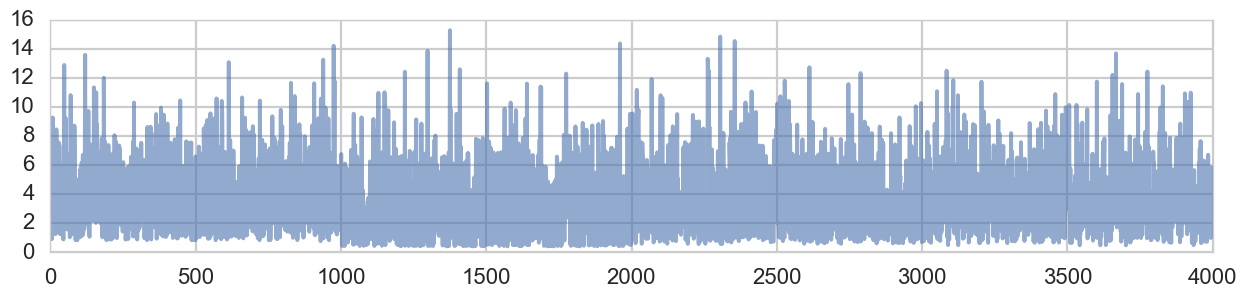

In [300]:
plt.figure(figsize=(15,3))
la = fit_cntrd.extract(permuted=True)
plt.plot(la['tau'], alpha=0.6)
plt.show()

Zoom into this trace a little to see some of the quirks going on:

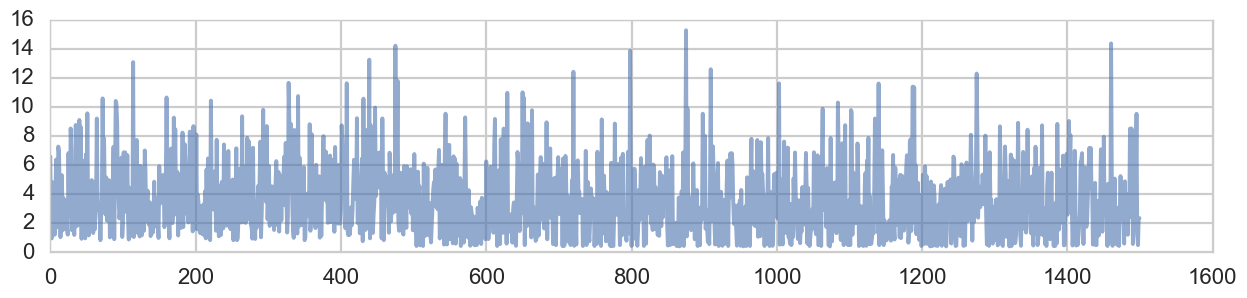

In [303]:
plt.figure(figsize=(15,3))
la = fit_cntrd.extract(permuted=True)
plt.plot(la['tau'][500:2000], alpha=0.6)
plt.show()

In [283]:
fit_noncntrd

Inference for Stan model: anon_model_4f41e77eed58ee2e5f2071c46920d9e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.33    0.05   3.34  -2.14   2.04   4.32   6.58  10.74   3708    1.0
tau              3.31    0.05    2.5   0.13   1.35   2.83    4.7   9.53   2898    1.0
theta_tilde[0]    0.3    0.02   0.99  -1.68  -0.37   0.29   0.98   2.24   4000    1.0
theta_tilde[1]   0.09    0.02   0.95  -1.82  -0.53   0.11   0.74   1.95   4000    1.0
theta_tilde[2]  -0.08    0.02   0.95   -2.0  -0.72  -0.08   0.56   1.78   4000    1.0
theta_tilde[3]   0.06    0.02   0.97  -1.83  -0.58   0.06   0.72   1.95   4000    1.0
theta_tilde[4]  -0.17    0.01   0.94  -2.01   -0.8  -0.15   0.48   1.68   4000    1.0
theta_tilde[5]  -0.09    0.01   0.91  -1.91   -0.7   -0.1   0.53   1.69   4000    1.0
theta_tilde[6]   0.36    0.02   0.97 

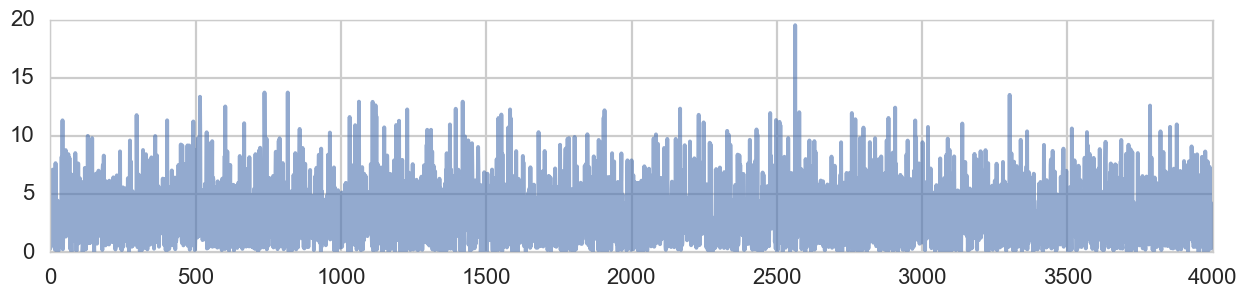

In [304]:
plt.figure(figsize=(15,3))
la = fit_noncntrd.extract(permuted=True)
plt.plot(la['tau'], alpha=0.6)
plt.show()

Compare number of divergences:

In [286]:
print("For the Centered Parameterization, count of divergences:", [np.sum(chain['divergent__']) for chain in fit_cntrd.get_sampler_params()])
print("For the Non-Centered Parameterization, count of divergences:", [np.sum(chain['divergent__']) for chain in fit_noncntrd.get_sampler_params()])

For the Centered Parameterization, count of divergences: [95.0, 147.0, 72.0, 88.0]
For the Non-Centered Parameterization, count of divergences: [20.0, 21.0, 18.0, 14.0]


Look how the centered paramaterization cannot effectively sample small values of tau. Non-centered gets a way better exploration of the space.

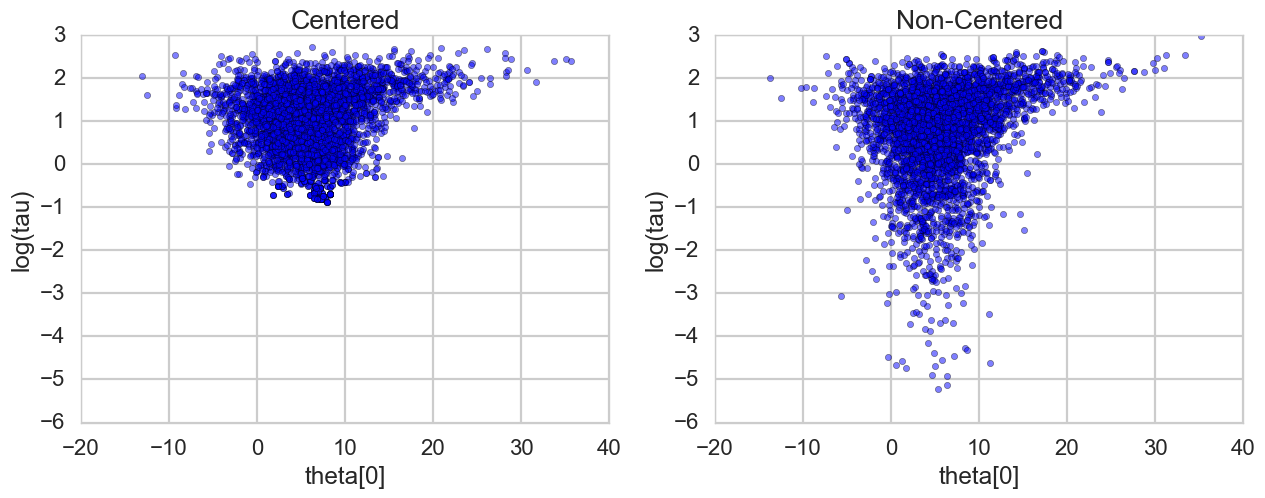

In [297]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

la = fit_cntrd.extract(permuted=True)
ax1.scatter(la.get('theta')[:,0], np.log(la.get('tau')), alpha=0.5)
ax1.set_title('Centered')

la = fit_noncntrd.extract(permuted=True)
ax2.scatter(la.get('theta')[:,0], np.log(la.get('tau')), alpha=0.5)
ax2.set_title('Non-Centered')

ax1.set_ylabel('log(tau)')
ax2.set_ylabel('log(tau)')
ax1.set_xlabel('theta[0]')
ax2.set_xlabel('theta[0]')

ax1.set_ylim([-6,3])
ax2.set_ylim([-6,3])

plt.show()

### Define the data generative model:

In [447]:
def generate_schools_cntrd():
    sigma = [15, 10, 16, 11,  9, 11, 10, 18]
    
    mu = np.random.normal(0, 5)
    tau = -1
    while tau < 0:
        tau = np.random.normal(0, 5)
    theta = np.random.normal(mu, tau, size=len(sigma))
    
    Y = []
    for i, sig in enumerate(sigma):
        Y.append(np.random.normal(theta[i], sig))

    return {'J': 8, 'sigma': sigma, 'y': Y, 'tau': tau, 'mu': mu, 'theta': theta}

def generate_schools_noncntrd():
    sigma = [15, 10, 16, 11,  9, 11, 10, 18]
    
    mu = np.random.normal(0, 5)
    tau = -1
    while tau < 0:
        tau = np.random.normal(0, 5)
    theta_tilda = np.random.normal(0, 1, size=len(sigma))
    theta = mu + tau*theta_tilda
    
    Y = []
    for i, sig in enumerate(sigma):
        Y.append(np.random.normal(theta[i], sigma[i]))

    return {'J': 8, 'sigma': sigma, 'y': Y, 'tau': tau, 'mu': mu, 'theta': theta}

# Schools Data - Algorithm 1 results:

In [448]:
cntrd_results = algorithm(
                    generate_schools_cntrd,
                    schools_model_cntrd,
                    ['mu', 'tau', 'theta'],
                    alg=1
                  )

In [449]:
noncntrd_results = algorithm(
                    generate_schools_noncntrd,
                    schools_model_noncntrd,
                    ['mu', 'tau', 'theta'],
                    alg=1
                  )

Centered:

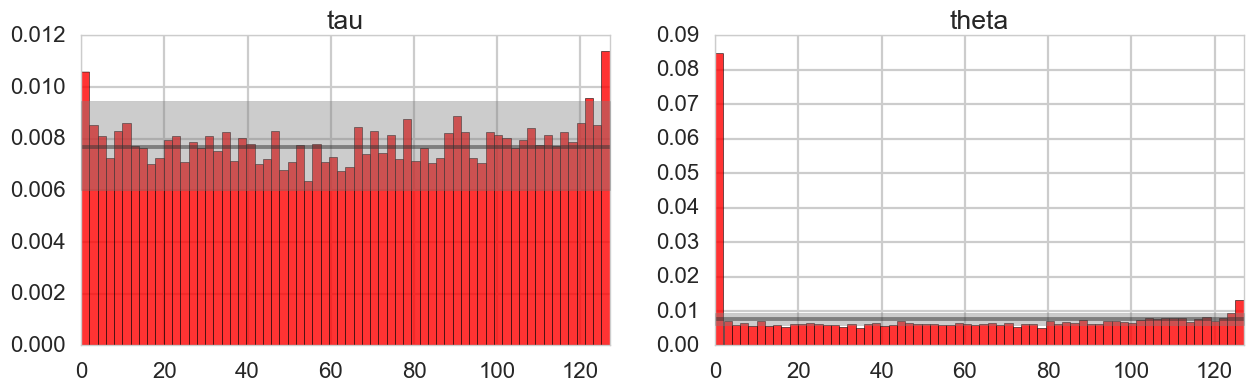

In [483]:
var = ['tau', 'theta']
mu, tau, theta = cntrd_results.values()

fig, axes = plt.subplots(1,2,figsize=(15,4))

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(tau, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[1].hist(theta, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])

for i,ax in enumerate(axes):
    ax.axhline(y=median/(N*2), alpha=0.5, color='black')
    ax.fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
    ax.set_title(var[i])
    ax.set_xlim([0,L])
    
plt.show()

Non-Centered:

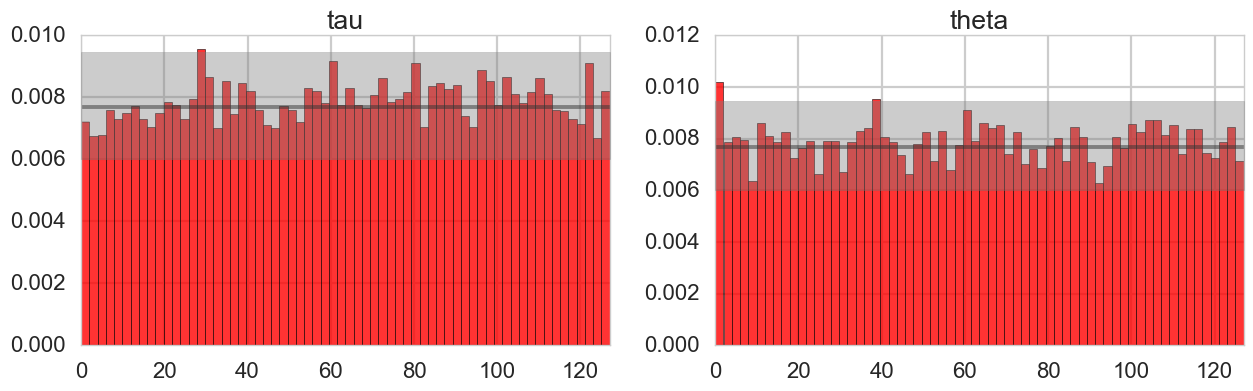

In [484]:
mu, tau, theta = noncntrd_results.values()

fig, axes = plt.subplots(1,2,figsize=(15,4))

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(tau, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[1].hist(theta, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])

for i,ax in enumerate(axes):
    ax.axhline(y=median/(N*2), alpha=0.5, color='black')
    ax.fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
    ax.set_title(var[i])
    ax.set_xlim([0,L])
    
plt.show()

# Schools Data - Algorithm 2 results:

In [462]:
cntrd_results2 = algorithm(
                    generate_schools_cntrd,
                    schools_model_cntrd,
                    ['mu', 'tau', 'theta'],
                    alg=2
                  )

In [463]:
noncntrd_results2 = algorithm(
                    generate_schools_noncntrd,
                    schools_model_noncntrd,
                    ['mu', 'tau', 'theta'],
                    alg=2
                  )

Centered:

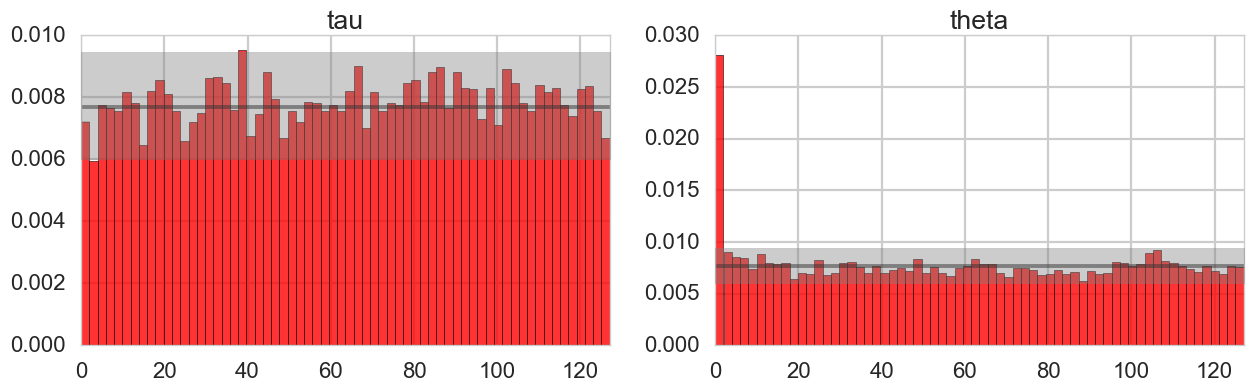

In [485]:
var = ['tau', 'theta']
mu, tau, theta = cntrd_results2.values()

fig, axes = plt.subplots(1,2,figsize=(15,4))

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(tau, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])
axes[1].hist(theta, alpha=0.8, normed=True, color='r', bins=bins, range=[0,L])

for i,ax in enumerate(axes):
    ax.axhline(y=median/(N*2), alpha=0.5, color='black')
    ax.fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
    ax.set_title(var[i])
    ax.set_xlim([0,L])
    
plt.show()

Non-Centered:

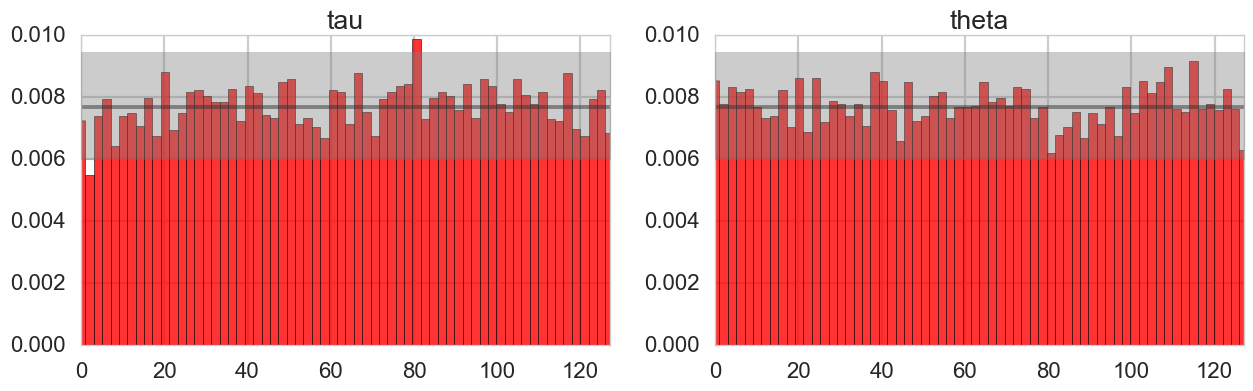

In [486]:
mu, tau, theta = noncntrd_results2.values()

fig, axes = plt.subplots(1,2,figsize=(15,4))

end_points = stats.binom(n=N, p=1/(bins+1)).interval(0.995)
median = stats.binom(n=N, p=1/(bins+1), loc=0).median()

axes[0].hist(tau, alpha=0.8, normed=True, color='r', bins=bins, range=[-1,L+1])
axes[1].hist(theta, alpha=0.8, normed=True, color='r', bins=bins, range=[-1,L+1])

for i,ax in enumerate(axes):
    ax.axhline(y=median/(N*2), alpha=0.5, color='black')
    ax.fill_between(x=np.arange(0,L+1), y1=end_points[0]/(N*2), y2=end_points[1]/(N*2), color='gray', alpha=0.4, zorder=100)
    ax.set_title(var[i])
    ax.set_xlim([0,L])
    
plt.show()